In [1]:
# This Jupyter Notebook generates a BETSE cell cluster and default simulation 
# object and points out some key data structures to help a Developer design
# new functionality for BETSE, or to use BETSE modules like a toolbox. 

# To comment/uncomment blocks of code, highlight the desired code and press 'ctrl' and '/'
# at the same time...

# Any questions please ask! 
# alexis.pietak@gmail.com

# Copyright Alexis Pietak

In [2]:
# Import statements:

import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib import colorbar
from matplotlib import rcParams
from matplotlib.collections import PolyCollection

from collections import OrderedDict
import math
import copy
import os
import os.path
import csv

from scipy.spatial import cKDTree

from betse.science.simrunner import SimRunner
from betse.science import filehandling as fh
from betse.science.math import modulate
from betse.util.path import files
from betse.science.phase.phasecls import SimPhase
from betse.science.enum.enumphase import SimPhaseKind
from betse.science.math import toolbox as tb
from betse.science.parameters import Parameters as p

[ipykernel_launcher.py] Loading third-party dependencies...


In [3]:
# This makes plots interactive (e.g. zoom, pan, saving, etc)

%matplotlib notebook 

In [4]:
# Supply the path to the 'sim_config.yaml' file in the unzipped 'Demo' folder provided: 

fno = '/home/pietakio/Adipose/BETSE_Study/Demo/sim_config.yaml'

In [5]:
class DemoSim(object):
    """
    Object allowing for simple creation of BETSE cell cluster and simulation object 
    that can be worked with in Jupyter Notebook. 
    
    """

    def __init__(self, *args, **kwargs):

        self.model_init(*args, **kwargs)  # Initializes the model when called
        
    def model_init(self, config_filename, new_mesh=False, verbose=True, 
                   run_init = True, run_sim = False):
        """
        Initializes the BETSE modelling object.
        
        Parameters:
        --------------
        config_filename: path to the configuration file
        new_mesh: whether to generate a whole new mesh or try to load a saved one
        verbose: spit out comments or stay silent
        run_init: whether to run through the BETSE initialization or not
        
        """

        # Make an instance of the BETSE 'parameters' object based on 
        # settings in the configuration file supplied:
        
        self.p = p.make(config_filename)

        self.verbose = verbose # save verbosity setting

        self.make_mesh(new_mesh = new_mesh) # make or load a BETSE cell cluster
        
        if run_init:
            self.init_demo(runsim = run_sim)
            
        if self.verbose is True:
            print("Successfully generated model!")
            
    def make_mesh(self, new_mesh=False):
        """
        Generates or loads a saved 2D Voronoi mesh for the BETSE simulation, based
        on settings in the supplied config file.

        """

        if new_mesh is True: # If 'new mesh' is requested, make a whole new cell cluster

            if self.verbose is True:
                print("Creating a new 2D Grid.")
                
            # Create a new grid:
            
            self.simrun = SimRunner(self.p) # Call an instance of BETSE's "SimRunner'
            phase = self.simrun.seed()   # Go through the making of a whole cell cluster
            self.phase = phase  # save the phase object (which contains the cell cluster
                                # to the DemoSim object) 
                

        else: # otherwise, if a new mesh isn't needed, go ahead and load a saved cluster,
              # if it exists!

            if not files.is_file(self.p.seed_pickle_filename): # If it doesn't exist...
                if self.verbose is True:
                    print("File not found; Creating a new 2D Grid")
                    
                # Make a new mesh
                
                self.simrun = SimRunner(self.p)  
                phase = self.simrun.seed() # Go ahead and make a new cluster
                self.phase = phase

            else:  # Otherwise, load the saved cell cluster:
                if self.verbose is True:
                    print("Loading a 2D Grid from file.")
                    
                # Load from previous creation:
                cells, _ = fh.loadWorld(self.p.seed_pickle_filename)
                
                self.simrun = SimRunner(self.p)  

                # Simulation phase, created after unpickling these objects above
                
                self.phase = SimPhase(
                    kind=SimPhaseKind.SEED,
                    p=self.p,
                    cells=cells,
                )

                # Initialize core simulation data structures.
                
                self.phase.sim.init_core(self.phase)
                self.phase.dyna.init_profiles(self.phase)

        # assign commonly used dimensional parameters to the DemoSim object:
        
        self.assign_easy_x(self.phase.cells)
        
        # Side Note #1 -------------------------------------------------------------
        
        # A note on mathematical operators that can be accessed (please see
        # the module BETSE/betse/science/cells for more information:
        
        # For a hypothetical scalar property 'F' defined at cell centres:
        # gFn, gFx, gFy = self.phase.cells.gradient(F) (gFn is component normal to mems)
        # Lap_F = np.dot(self.phase.cells.lapGJ_P, F)
        
        # For a hypothetical vector field Fx, Fy, defined at membrane mids:
        # div_F = self.phase.cells.div(Fx, Fy) # divergence of Fx, Fy
        
        # To average a quantity F defined at membrane mids to the centerpoint between two
        # cells:
        # F_at_mem_ave = self.phase.cells.meanval(F)
        
        # To average a vector field from the membrane edge of each cell (Fmx, Fmy) to 
        # the centre of each cell:
        # Fcx, Fcy = self.phase.cells.average_vector(Fmx, Fmy)
        
        # Side Note #2---------------------------------------------------------------
        # There are many ways to move between different point systems in BETSE's grids:
        # for example, self.phase.cells.mem_to_cells[Fc] will take a property, Fc, defined at
        # the cell centre points, and copy it to all membranes of the cell. Indices can
        # be accessed this way as well. There are also maps to move the other way around
        # (self.phase.cells.cell_to_mems), so find boundary points (self.cells.bflags_mems
        # supplies all membranes on the outer boundary), and so on.
        # To map between the environmental grid and the membrane midpoints, use
        # the "cells.map_mem2ecm" datastructure. For example, to take the difference
        # beteen the environmental concentration of sodium ions and the cytosolic
        # concentration:
        # sim.cc_env[sim.iNa][cells.map_mem2ecm] - self.cc_at_mem[sim.iNa]
        # If the centre of cells is desired instead of the midpoints, use:
        # "cells.map_cell2ecm" in the same manner as above. 
        
    def init_demo(self, runsim = False):
        """
        Run the BETSE cell cluster through the initialization specified in 
        the loaded configuration file. 
        
        """
        
        self.phase = self.simrun.init()
        
        if runsim:
            self.phase = self.simrun.sim()
        
        # short forms of commonly used data structures from BETSE sim object, based on
        # ion settings for 'basic' profile:
        
        # Data defined on cell centrepoints (self.xc, self.yc):
        
        self.vm_ave = self.phase.sim.vm_ave # Vmem state averaged over a whole cell [V]
        self.cc_cells = self.phase.sim.cc_cells # Array of cytosolic ion conc arrays [mol/m^3]
        self.Ex = self.phase.sim.E_cell_x # x-component of electric field [V/m]
        self.Ey = self.phase.sim.E_cell_y # y-component of electric field [V/m]
        self.rho_cells = self.phase.sim.rho_cells # charge density [C/m^3]
        
        # Data defined on membrane midpoints (self.xm, self.ym):
        
        self.vm = self.phase.sim.vm # Vmem defined at cell edges (membranes) [V]
        self.Dm_cells = self.phase.sim.Dm_cells # Array of mem diffusion constant arrays [m^2/s]
        
        # Data defined on environmental points (self.xenv, self.yenv)
        
        self.cc_env = self.phase.sim.cc_env # Array of extracellular ion conc arrays [mol/m^3]
        
        # Single-value data (one value for each ion included in the simulation)
        
        self.D_free = self.phase.sim.D_free # Array of media diffusion constant arrays [m^2/s]
        
        # Numerical indices to access specific ions in cc_cells, Dm_cells, cc_env, etc
        
        self.iNa = self.phase.sim.iNa # Index of Na ion in array-of-arrays 
        self.iK = self.phase.sim.iK # Index of K ion in array-of-arrays 
        self.iM = self.phase.sim.iM # Index of M ion in array-of-arrays 
        self.iP = self.phase.sim.iP # Index of P ion in array-of-arrays 
        
        
    def assign_easy_x(self, cells):
        """
        Assigns short forms to commonly used mesh components.
        
        Parameters
        -----------
        cells: a Betse cell cluster object
        
        """
        
        # points of cell centres:
        
        self.xc = cells.cell_centres[:, 0]
        self.yc = cells.cell_centres[:, 1]
        
        # membrane midpoints for edges of each cell:
        
        self.xmem = cells.mem_mids_flat[:, 0]
        self.ymem = cells.mem_mids_flat[:, 1]

        # points of the square environmental grid:
        
        self.xenv = cells.xypts[:, 0]
        self.yenv = cells.xypts[:, 1]

        # global size limits of the whole environment and cell cluster:
        
        self.xyaxis = np.asarray([cells.xmin, cells.xmax, cells.ymin, cells.ymax])

        # vertices of each polygon representing each cell in the cluster:
        self.verts = cells.cell_verts

        # Normal vectors to membrane edges
        self.nx = cells.mem_vects_flat[:, 2]
        self.ny = cells.mem_vects_flat[:, 3]
        
        # true extracellular matrix points (point shared between two membrane mids):
        self.xec = cells.ecm_mids[:,0]
        self.yec = cells.ecm_mids[:,1]

        # assign length of cell (cdl), mems (mdl) and env (edl) of mesh:
        
        self.cdl = len(cells.cell_i)
        self.mdl = len(cells.mem_i)
        self.edl = len(cells.ecm_mids)
        self.envdl = len(cells.xypts)


In [6]:
model = DemoSim(fno, new_mesh=True, run_init = True)

Creating a new 2D Grid.
[ipykernel_launcher.py] Seeding simulation...
[ipykernel_launcher.py] Creating hexagonal cell lattice...
[ipykernel_launcher.py] Creating Voronoi geometry... 
[ipykernel_launcher.py] Creating triangular mesh...
[ipykernel_launcher.py] Check for unused vertices...
[ipykernel_launcher.py] Merging close circumcenters...
[ipykernel_launcher.py] Defining edges of tri mesh...
[ipykernel_launcher.py] Calculating Voronoi cells...
[ipykernel_launcher.py] Calculating Voronoi edges...
[ipykernel_launcher.py] Creating triangular mesh...
[ipykernel_launcher.py] Check for unused vertices...
[ipykernel_launcher.py] Merging close circumcenters...
[ipykernel_launcher.py] Defining edges of tri mesh...
[ipykernel_launcher.py] Calculating Voronoi cells...
[ipykernel_launcher.py] Calculating Voronoi edges...
[ipykernel_launcher.py] Initializing Voronoi mesh optimization...
[ipykernel_launcher.py] Creating triangular mesh...
[ipykernel_launcher.py] Check for unused vertices...
[ipyke

[ipykernel_launcher.py] Creating triangular mesh...
[ipykernel_launcher.py] Check for unused vertices...
[ipykernel_launcher.py] Merging close circumcenters...
[ipykernel_launcher.py] Defining edges of tri mesh...
[ipykernel_launcher.py] Calculating Voronoi cells...
[ipykernel_launcher.py] Calculating Voronoi edges...
[ipykernel_launcher.py] Creating core operators...
[ipykernel_launcher.py] Creating auxiliary operators...
[ipykernel_launcher.py] Mesh creation complete!
[ipykernel_launcher.py] Creating computational matrices for cell-cell transfers...
[ipykernel_launcher.py] Creating gap junctions... 
[ipykernel_launcher.py] Creating core computational matrices...
[ipykernel_launcher.py] Cell cluster creation complete!
[ipykernel_launcher.py] This world contains 226 cells.
[ipykernel_launcher.py] Each cell has an average of 5.53 nearest-neighbours.
[ipykernel_launcher.py] The "basic" ion profile enables the "sodium", "potassium", "proteins", and "anion" ions.
[ipykernel_launcher.py] If

<IPython.core.display.Javascript object>


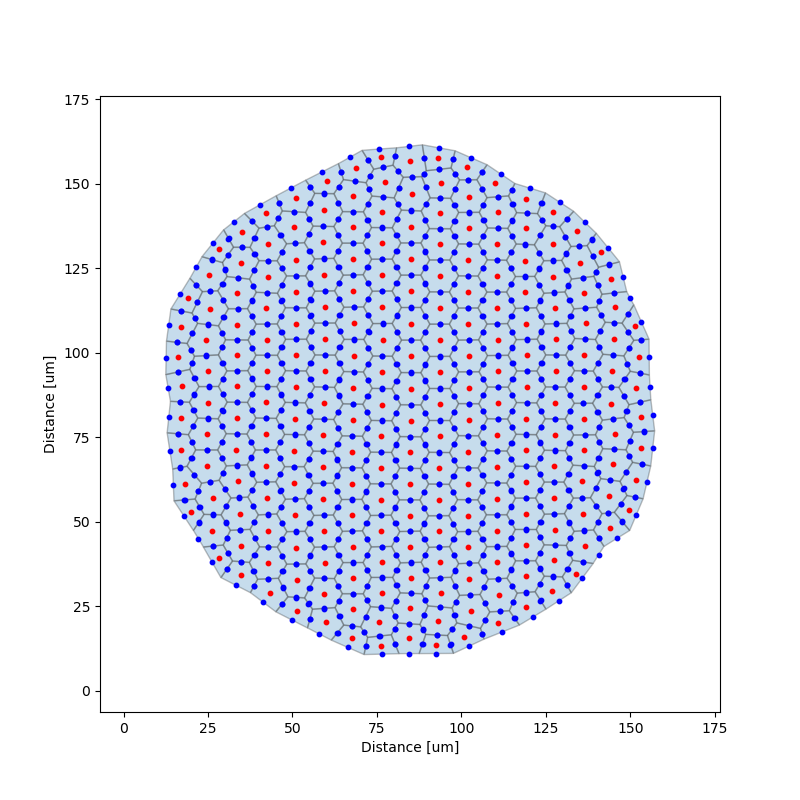

In [7]:
# First take a look at grid elements to understand different features....

plt.figure(figsize = (8,8))
ax = plt.subplot(111)

# Define a polygon collection from the vertices of each cell defined in model.verts
# Multiplication by 1e6 is just to make sizes in micrometers instead of meters...

col1 = PolyCollection(model.verts*1e6, edgecolor='black', linewidth=1.0)
col1.set_alpha(0.25) # make the color a little less bold
ax.add_collection(col1)

# Next plot the cell centrepoints as red dots:
plt.scatter(model.xc*1e6, model.yc*1e6, color = 'red', s =10)

# Plot the membrane midpoints as blue dots:
# (if you zoom in, you'll see the blue dots are almost redundant, with each cell having
# a closed polygon cell -- this is to allow for single cell polarization states)
plt.scatter(model.xmem*1e6, model.ymem*1e6, color = 'blue', s =10)

# # Plot the 'environmental' grid as a black dots:
# plt.scatter(model.xenv*1e6, model.yenv*1e6, color = 'black', s =10)

plt.axis('equal')
plt.axis(model.xyaxis*1e6)
plt.xlabel('Distance [um]')
plt.ylabel('Distance [um]')
plt.show()

<IPython.core.display.Javascript object>


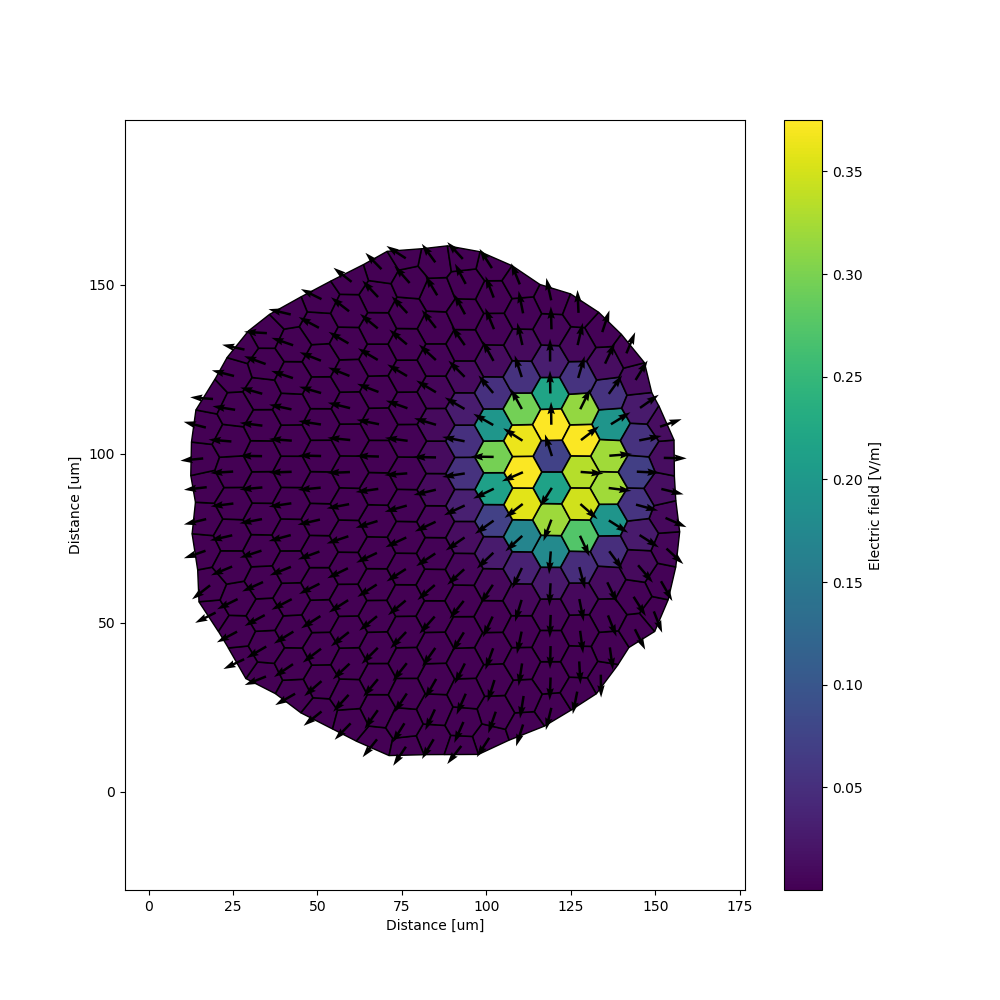

In [8]:
# Next take a look at a vector field and plotting....

# calculate magnitude of long-range electric field in cells (arising from 
# endogenous current density):

Emag = model.phase.cells.mag(model.Ex, model.Ey) 
Ex = model.Ex/Emag # Normalize the field for plotting
Ey = model.Ey/Emag

plt.figure(figsize = (10,10))
ax = plt.subplot(111)

# Define a polygon collection from the vertices of each cell defined in model.verts
# Multiplication by 1e6 is just to make sizes in micrometers instead of meters...

col1 = PolyCollection(model.verts*1e6, edgecolor='black', linewidth=1.0)
col1.set_array(Emag) # make the cell color show the electric field magnitude
ax.add_collection(col1)

cb = plt.colorbar(col1) # add a colorbar
cb.set_label('Electric field [V/m]')

# Plot the vector field:

plt.quiver(model.xc*1e6, model.yc*1e6, Ex, Ey)

plt.axis('equal')
plt.axis(model.xyaxis*1e6)
plt.xlabel('Distance [um]')
plt.ylabel('Distance [um]')
plt.show()

# Cool thing: can you write a script to efficiently deform the Voronoi cell cluster points 
# (moving cell centres, verts, ecm and membrane points, etc) under the action of
# a force field? 

<IPython.core.display.Javascript object>


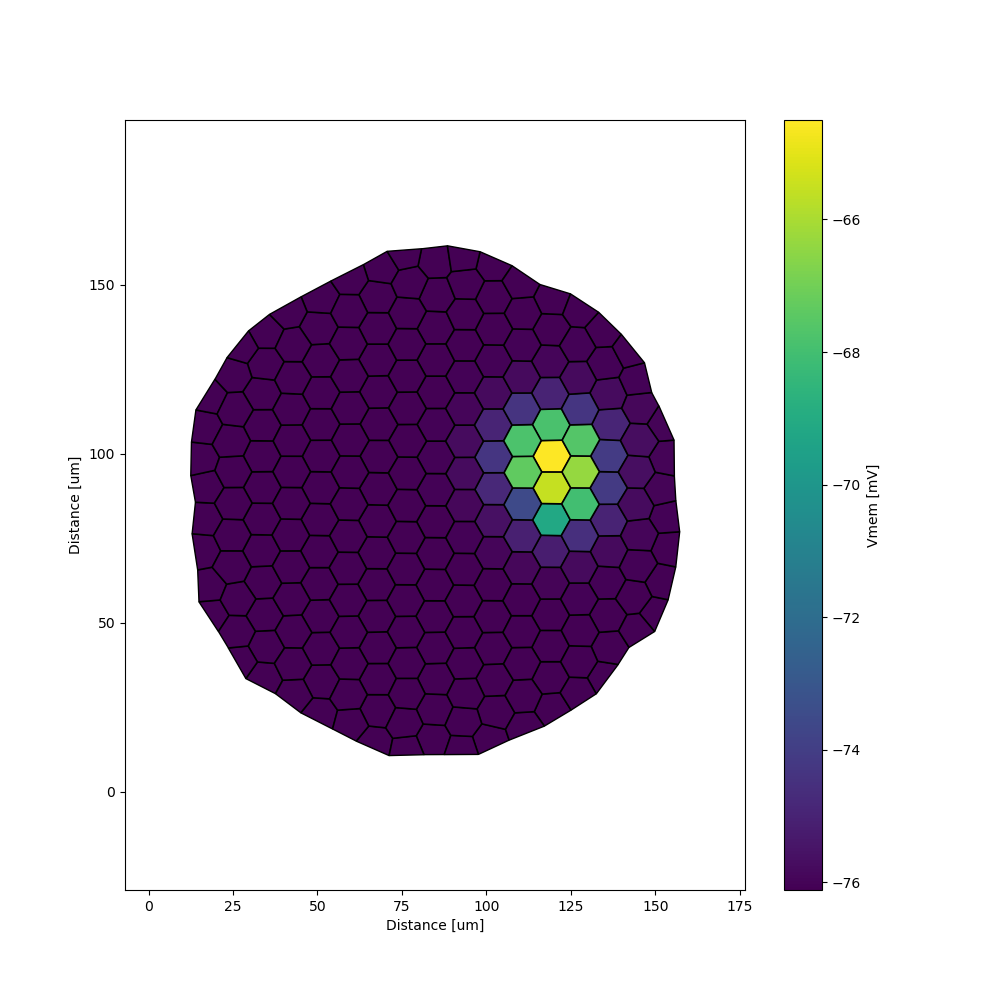

In [9]:
# Plotting a scalar property (e.g. cell-average of Vmem) on a grid that shows each cell
# as a polygon

plt.figure(figsize = (10,10))
ax = plt.subplot(111)

col1 = PolyCollection(model.verts*1e6, edgecolor='black', linewidth=1.0)

col1.set_array(model.vm_ave*1e3)

ax.add_collection(col1)

cb = plt.colorbar(col1)
cb.set_label('Vmem [mV]')

plt.axis('equal')
plt.axis(model.xyaxis*1e6)
plt.xlabel('Distance [um]')
plt.ylabel('Distance [um]')
plt.show()

<IPython.core.display.Javascript object>


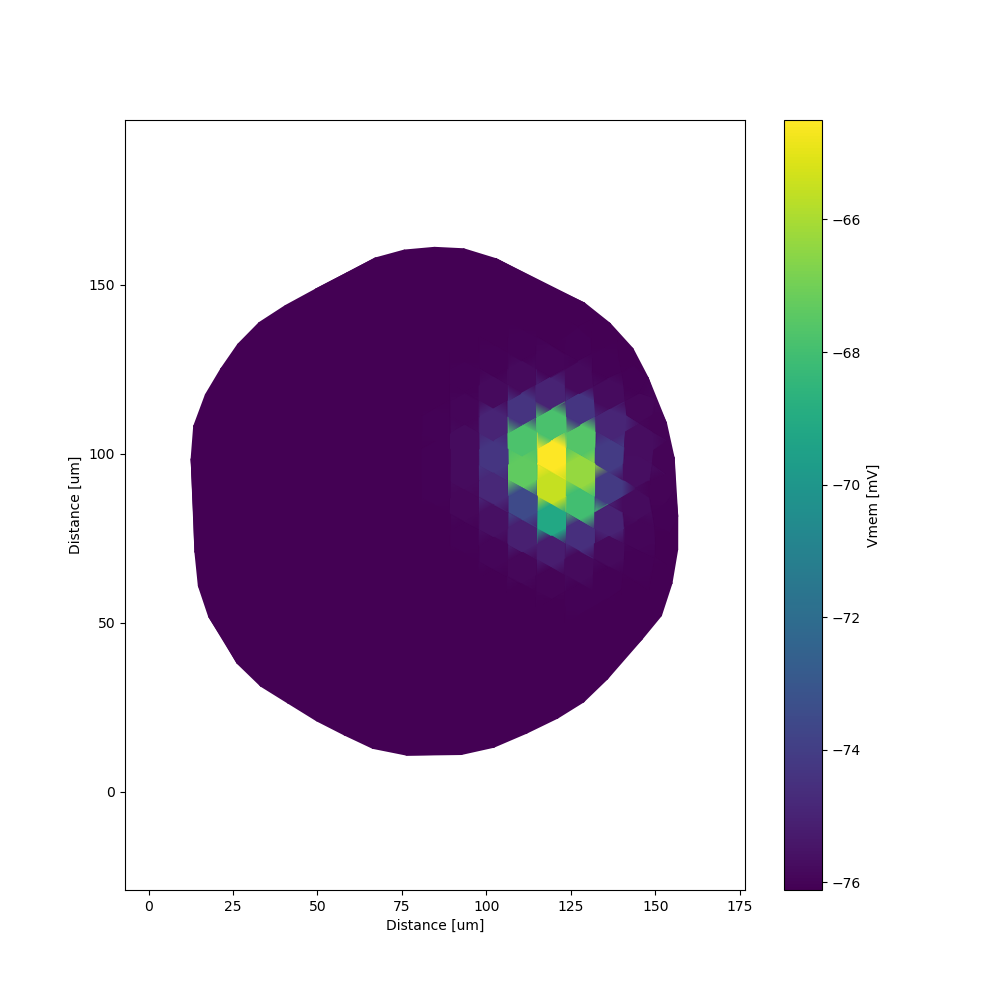

In [10]:
# Plotting a scalar property defined on membrane-midpoints (cell edges) on a 
# smoothed mesh:

plt.figure(figsize = (10,10))
plt.tripcolor(model.xmem*1e6, model.ymem*1e6, model.vm*1e3, shading = 'gouraud')
cb = plt.colorbar()
cb.set_label('Vmem [mV]')
plt.axis('equal')
plt.xlabel('Distance [um]')
plt.ylabel('Distance [um]')
plt.axis(model.xyaxis*1e6)
plt.show()

In [11]:
# MATHEMATICAL OPERATORS

# Gradient
grad=model.phase.cells.gradient

# Divergence
div=model.phase.cells.div

# Laplacian
lap=model.phase.cells.lapGJ # Neuman (zero-flux) boundary conditions

# Inverse Laplacian
inv_lap=model.phase.cells.lapGJinv # Neuman (zero-flux) boundary conditions

cell_to_mems=model.phase.cells.cell_to_mems # From cell centers to membrane mid-points
mem_to_cells=model.phase.cells.mem_to_cells # From membrane mid-points to cell centers

meanval = model.phase.cells.meanval # Interpolates value between cell centre to mem mids

ave_vect = model.phase.cells.average_vector # averages vectors from mem mids to cell centre

nn_i = model.phase.cells.nn_i
mem_i = model.phase.cells.mem_i

M_sum_mems = model.phase.cells.M_sum_mems
mem_sa = model.phase.cells.mem_sa
cell_sa = model.phase.cells.cell_sa